Leer primero los archivos h5 de train y test y crear un df con pandas. Luego, separamos el df en train y test.

In [2]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from tsfresh import extract_features
from tsfresh.utilities.distribution import MultiprocessingDistributor
from tsfresh.feature_extraction import EfficientFCParameters
import os

with h5py.File('train.h5', 'r') as f:
    X = f['x'][:]
    Y = f['y'][:]

print(X.shape)
print(Y.shape)

# Convierte X a un DataFrame de pandas
df_X = pd.DataFrame(X.reshape(-1, X.shape[-1]))

# Convierte Y a un DataFrame de pandas
df_Y = pd.DataFrame(Y, columns=['Target'])

# Une los dos DataFrames
df = pd.concat([df_X, df_Y], axis=1)

# print(df)

num_trials = 18530

df_tsfresh = pd.DataFrame({
    'id': np.repeat(df.index, num_trials),
    'time': np.tile(np.arange(num_trials), len(df)),
    'value': df.drop(columns='Target').values.flatten()
})


#use test.h5 and predict the target and save it in a file
with h5py.File('test.h5', 'r') as f:
    XX = f['x'][:]

# Convierte X a un DataFrame de pandas
df_X_test = pd.DataFrame(XX.reshape(-1, X.shape[-1]))

df_tsfresh_test = pd.DataFrame({
    'id': np.repeat(df_X_test.index, num_trials),
    'time': np.tile(np.arange(num_trials), len(df_X_test)),
    'value': df_X_test.values.flatten()
})

# print(df_tsfresh_test)

# # draw the first time series for trial 1 with the labels and title, and save it in a file, also include the legend
# plt.plot(df_tsfresh[df_tsfresh['id'] == 0]['time'], df_tsfresh[df_tsfresh['id'] == 0]['value'])
# plt.legend(['Trial 1'])
# plt.title('Trial 1')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.savefig('trial_1.png')
# plt.show()

# #do the same for trial 10
# plt.plot(df_tsfresh[df_tsfresh['id'] == 9]['time'], df_tsfresh[df_tsfresh['id'] == 9]['value'])
# plt.legend(['Trial 10'])
# plt.title('Trial 10')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.savefig('trial_10.png')
# plt.show()

(204, 1, 18530)
(204,)


Luego extraemos las features de los archivos h5 con tsfresh

In [30]:
Distributor1 = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")
Distributor2 = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")

from tsfresh.feature_extraction.settings import MinimalFCParameters

custom_settings = {
    "absolute_sum_of_changes": None,
    "mean": None,
    "variance": None,
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"}
    ],
    "permutation_entropy": [{"tau": 1, "dimension": 3}],
    #"fractal_dimension": [{"method": "katz"}, {"method": "petrosian"}]
}




features = extract_features(df_tsfresh, column_id='id', column_sort='time', distributor=Distributor1, default_fc_parameters=custom_settings)
features_test = extract_features(df_tsfresh_test, column_id='id', column_sort='time', distributor=Distributor2, default_fc_parameters=custom_settings)


Feature Extraction: 100%|██████████| 103/103 [00:00<00:00, 216.57it/s]


Después, separamos las features en train y test y las guardamos en archivos csv.

In [31]:
#save features in a file.csv
features.to_csv("features_train.csv", index=False)

#save features_test in a file.csv
features_test.to_csv("features_test.csv", index=False)

#save y in a file.csv
df_Y.to_csv("y_train.csv", index=False)

Mas adelante, cargamos las features de train de sus csv y las dividimos en train y validation.

In [5]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Cargar los datos
df = pd.read_csv('features_train.csv')
y = pd.read_csv('y_train.csv')
X = df
y = y['Target']


PCA ANALISIS

In [13]:
#import pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X)

x_train_scaled = np.nan_to_num(x_train_scaled)


# Seleccionar el número de componentes principales
pca2 = PCA()
pca2.fit(x_train_scaled)

eigen_vecs = pca2.components_
#print(eigen_vecs.shape)

# Transformar los datos al nuevo espacio
features_transformed = pca2.transform(x_train_scaled)      # features_transformed es un numpy array
features_imputed = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

# DATA CON PCA
X = features_imputed
Y = df_Y['Target']
print(X.shape)
print(Y.shape)

(204, 5)
(204,)


Despues, elegimos algun modelo de clasificación y lo entrenamos con las features de train y validamos con las features de validation.

In [7]:
#import logistic regression
# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        46
           1       0.46      0.38      0.41        16

    accuracy                           0.73        62
   macro avg       0.63      0.61      0.62        62
weighted avg       0.71      0.73      0.72        62

0.7258064516129032


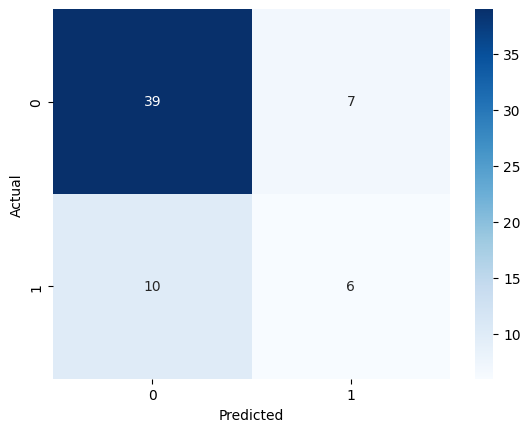

In [29]:
#import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Crea un clasificador KNN
clf = RandomForestClassifier(n_estimators=10, random_state=42)
# Entrena el clasificador
clf.fit(X_train, y_train)

# Haz predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Muestra el reporte de clasificación
print(classification_report(y_test, y_pred))

#get accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

#create confusion matrix
from sklearn.metrics import confusion_matrix

#plot confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Finalmente predecimos las features de test y las guardamos en un archivo csv.

In [ ]:
X_test = pd.read_csv('features_test.csv')
X_test = X_test.fillna(0)

# X_test = pca.transform(X_test)

# Haz predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)


#save y_pred in a file.csv with id and result. id starts from 1
df_y_pred = pd.DataFrame(y_pred, columns=['result'])
df_y_pred.index += 1
df_y_pred.index.name = 'ID'
df_y_pred.to_csv("y_pred.csv")